### Import Libraries

In [49]:
# Import libraries
import os 
import sys
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
import json
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Image
import IPython.display as ipd
from tqdm import tqdm, tqdm_pandas
import random
import gc
import time
import pickle
from vit_pytorch.efficient import ViT
from linformer import Linformer

### Read in data

In [50]:
Train_pt_DIR = './train_pt'
Train_Metadata_DIR = './train_metadata.csv'
Scored_Bird_DIR ='./scored_birds.json'
Train_DIR = './train_audio/'
Audio_Rating_Dir = "./bird_audio_rating_mapping.pkl"

#read in metadata as df
train_df = pd.read_csv(Train_Metadata_DIR)
train_df.head()
train_df['dir'] = Train_DIR+train_df['filename']
#print(train_df['dir'])
tqdm.pandas()
#train_df['spectrogram'] = train_df.progress_apply(lambda x: process_audio_to_spectrogram(x['dir']),axis=1)

In [ ]:
'''
num_audio_files = train_df.shape[0]

spectrograms_list = []
for i in tqdm(range(100)):
    current_bird = train_df.primary_label.loc[i]
    process_get_audio_chunks_images(train_df['dir'].iloc[i])
'''

In [52]:
def get_spectrograms_from_file(idx):
    #get all the corresponding spectrogram in np format
    bird = idx2bird[idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216)
    num_training_samples = x_train.shape[0]
    #y_train is one hot encoded vector per training sample
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,idx] = 1
    y_train = torch.cat([y_train]*num_training_samples)

    return x_train, y_train

In [53]:
def get_single_spectrogram_from_file(bird_idx, row):
    #get only 1 spectrogram based on the bird, and one particular row
    bird = idx2bird[bird_idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216) # to convert to N,C, H, W format
    #print(bird, row)
    x_train = x_train[row]
    x_train = x_train.view(-1,1,128,216)
    
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,bird_idx] = 1
    
    return x_train, y_train

In [54]:
def get_n_training_spectrograms_from_file(idx, n_spectrograms, TRAINING_VAL_SPLIT):
    #get n random spectrogram (np format) of selected bird
    bird = idx2bird[idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216) # to convert to N,C, H, W format
    
    train_index = int(TRAINING_VAL_SPLIT*len(x_train)) #80:20 split for training and validation
    
    indices = torch.randint(0,train_index,(n_spectrograms,)) #only sample from training pool
    selected_X_train = x_train[indices]
    
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,idx] = 1
    selected_y_train = torch.cat([y_train]*n_spectrograms)
    
    return selected_X_train, selected_y_train

In [55]:
a = torch.load('./train_pt/hudgod.pt')
print(a.shape)
b = torch.load('./train_pt/redpha1.pt')
print(b.shape)

torch.Size([41, 128, 216])
torch.Size([325, 128, 216])


### Noise Reduction

In [56]:
def noise_reduction(y, sr, plot=True, th=0.3):
    from scipy.fft import fft, fftfreq, ifft
    
    SAMPLE_RATE = 1
    DURATION = len(y) / SAMPLE_RATE
    N = int(SAMPLE_RATE * DURATION)

    yf = fft(y)
    xf = fftfreq(N, 1 / SAMPLE_RATE)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(24, 8))
        axes[0].plot(np.arange(len(y)), y)
        axes[0].set_title('Before Time-Domain')
        axes[1].plot(xf, np.abs(yf))
        axes[1].set_title('Before Frequency-Domain')
        plt.show()
    
    # Filtering Low-Pass
    new_yf = yf.copy()
    middle = len(y) / 2
    new_yf[int(middle - len(y) * th):int(middle + len(y) * th)] = 0
    new_y = ifft(new_yf)
    new_y = new_y.real
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(24, 8))
        axes[0].plot(np.arange(len(y)), new_y)
        axes[0].set_title('After Time-Domain')
        axes[1].plot(xf, np.abs(new_yf))
        axes[1].set_title('After Frequency-Domain')
        plt.show()

    return new_y, sr

### EDA

In [57]:
all_birds = list(train_df.primary_label.dropna().unique())
print('Total number of birds',len(all_birds))

Total number of birds 152


In [58]:
print(all_birds[0])

afrsil1


In [59]:
#for mapping of bird (str) to idx (int)
bird2idx = {}
for i, bird in enumerate(all_birds):
    bird2idx[bird] = i
    
idx2bird = {}
for _, (k, v) in enumerate(bird2idx.items()): 
    idx2bird[v] = k 

In [60]:
idx2bird[151]
bird2idx['zebdov']

151

Total number of birds 152
Scored birds ['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']
Number of scored birds training files 
 akiapo      14
aniani      12
apapan      47
barpet      15
crehon       2
elepai      14
ercfra       6
hawama      21
hawcre      20
hawgoo       9
hawhaw       3
hawpet1      3
houfin     322
iiwi        37
jabwar      78
maupar       1
omao        21
puaioh       3
skylar     500
warwhe1     71
yefcan      67
Name: primary_label, dtype: int64

Number of training files per bird


<AxesSubplot:>

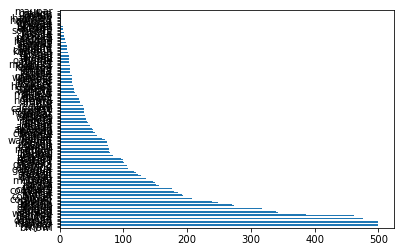

In [61]:
all_birds = list(train_df.primary_label.dropna().unique())
print('Total number of birds',len(all_birds))

#load scored birds 
with open(Scored_Bird_DIR) as sbfile:
    scored_birds = json.load(sbfile)
print('Scored birds',scored_birds)

bird_training_sample = train_df.primary_label.value_counts()

print('Number of scored birds training files \n',bird_training_sample.loc[scored_birds])
print()
print('Number of training files per bird')
bird_training_sample.plot(kind='barh')


In [62]:
#EDA, did the number of training data (5s) per bird
num_training_data = {}
for bird in tqdm(all_birds):
    _, y_train_bird = get_spectrograms_from_file(bird2idx[bird])
    num_training_data[bird] = len(y_train_bird)
sorted_training_data = sorted(num_training_data.items(), key = lambda kv: kv[1])
print(sorted_training_data)

scored_bird_training = {}
for bird in tqdm(scored_birds):
    scored_bird_training[bird] = num_training_data[bird]
sorted_scored_bird_training_data = sorted(scored_bird_training.items(), key = lambda kv: kv[1])
print(sorted_scored_bird_training_data)

100%|███████████████████████████████████████████████████| 152/152 [00:33<00:00,  4.54it/s]


[('bubsan', 3), ('coopet', 4), ('shtsan', 4), ('layalb', 6), ('puaioh', 7), ('ercfra', 11), ('mauala', 15), ('akikik', 20), ('chemun', 22), ('crehon', 23), ('lessca', 28), ('hawpet1', 32), ('hawgoo', 41), ('hudgod', 41), ('brnnod', 42), ('palila', 43), ('sopsku1', 44), ('kauama', 45), ('pomjae', 47), ('hawcoo', 48), ('maupar', 49), ('chbsan', 51), ('hawhaw', 52), ('oahama', 55), ('bulpet', 63), ('wantat1', 63), ('akekee', 65), ('yebcar', 69), ('incter1', 81), ('brtcur', 82), ('aniani', 83), ('sooter1', 85), ('brnboo', 87), ('golphe', 88), ('blknod', 90), ('buffle', 92), ('afrsil1', 96), ('whttro', 97), ('cintea', 98), ('madpet', 101), ('ruff', 101), ('canvas', 107), ('masboo', 112), ('sooshe', 116), ('bkwpet', 117), ('kalphe', 119), ('whiter', 121), ('grefri', 122), ('burpar', 124), ('rinduc', 126), ('elepai', 131), ('gresca', 134), ('hawama', 140), ('akiapo', 145), ('hoomer', 162), ('gryfra', 170), ('fragul', 179), ('refboo', 185), ('lcspet', 189), ('pagplo', 191), ('whfibi', 191), ('

100%|██████████████████████████████████████████████████| 21/21 [00:00<00:00, 92134.29it/s]

[('puaioh', 7), ('ercfra', 11), ('crehon', 23), ('hawpet1', 32), ('hawgoo', 41), ('maupar', 49), ('hawhaw', 52), ('aniani', 83), ('elepai', 131), ('hawama', 140), ('akiapo', 145), ('barpet', 195), ('omao', 224), ('iiwi', 418), ('yefcan', 427), ('hawcre', 484), ('apapan', 493), ('warwhe1', 500), ('jabwar', 803), ('houfin', 3260), ('skylar', 5296)]


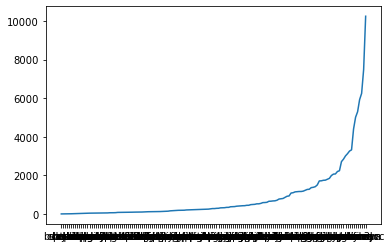

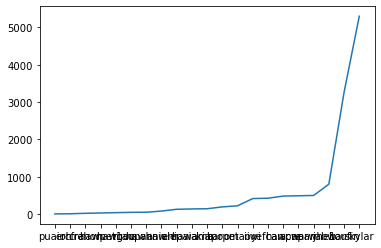

In [63]:
x, y = zip(*sorted_training_data) 
plt.plot(x, y)
plt.show()

x, y = zip(*sorted_scored_bird_training_data) 
plt.plot(x, y)
plt.show()

### Generate training data in .pt

In [64]:
def get_spectrograms(filename, ignore_silent=True):
    audio, sr = librosa.load(filename)
    clips = librosa.effects.split(audio, top_db=25)
    
    # display("Audio", ipd.Audio(data=audio, rate=sr))
    # plt.figure()
    # librosa.display.waveshow(audio, sr=sr)
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # plt.show()
    
    audio_len = len(audio)
    # 5 seconds chunk
    chunk_duration = 5
    buffer = sr * chunk_duration
    buffer_curr = 0
    
    spectrograms = []
    while buffer_curr < audio_len - buffer:
        if buffer > (audio_len - buffer_curr):
            buffer = audio_len - buffer_curr
        
        is_silent = True
        for c in clips:
            if len(range(max(buffer_curr, c[0]), min(buffer_curr + buffer, c[-1])+1)) > 0:
                is_silent = False
                break

        if is_silent:
            buffer_curr += buffer
            continue
            
        y = audio[buffer_curr:(buffer_curr + buffer)]
        # display("Audio with noise", ipd.Audio(data=y, rate=sr))
        nr_y, nr_sr = noise_reduction(y, sr, plot=False, th=0.3)
        # display("Audio with noise reduction", ipd.Audio(data=nr_y, rate=sr))
        
        buffer_curr += buffer

        S = librosa.feature.melspectrogram(y=nr_y, sr=nr_sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        if S_DB.shape != (128,216):
            temp = np.full((128,216),-80)
            temp[:S_DB.shape[0],:S_DB.shape[1]] = S_DB
            S_DB = temp
        spectrograms.append(S_DB)
    return spectrograms

In [ ]:
'''#generate pt files
num_audio_files = train_df.shape[0]

spectrograms_list = []
for i in tqdm(range(num_audio_files)):
    current_bird = train_df.primary_label.loc[i]
    #print('previous_bird',previous_bird)
    #print('current_bird',current_bird)
    spectrograms_list += get_spectrograms(train_df['dir'].iloc[i])
    if i+1 == num_audio_files:
        torch.save(torch.tensor(np.array(spectrograms_list)), './train_pt/'+current_bird+'.pt')
    else:
        next_bird = train_df.primary_label.loc[i+1]
        #print('next_bird',next_bird)
        if next_bird != current_bird:
            torch.save(torch.tensor(np.array(spectrograms_list)), './train_pt/'+current_bird+'.pt')
            spectrograms_list = []
    previous_bird = current_bird
    #print(spectrograms_list[0])'''

### Get the audio rating for each of the training sample

In [ ]:
'''
num_audio_files = train_df.shape[0]

def get_num_spectrograms_per_audio(filename):
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=filename)
    num_spectrogram = int(duration/chunk_duration)
    
    return num_spectrogram

bird_audio_rating_mapping = {}
audio_rating_list = []
for i in tqdm(range(num_audio_files)):
    current_bird = train_df.primary_label.loc[i]
    audio_rating = train_df['rating'].iloc[i]
    if audio_rating == 0:
        audio_rating = 2.5
    num_spec = get_num_spectrograms_per_audio(train_df['dir'].iloc[i])
    audio_rating_list += [audio_rating]*num_spec
    if i+1 == num_audio_files:
        bird_audio_rating_mapping[current_bird] = audio_rating_list
        #torch.save(torch.tensor(np.array(spectrograms_list)), './train_pt/'+current_bird+'.pt')
    else:
        next_bird = train_df.primary_label.loc[i+1]
        if next_bird != current_bird:
            bird_audio_rating_mapping[current_bird] = audio_rating_list
            #torch.save(torch.tensor(np.array(spectrograms_list)), './train_pt/'+current_bird+'.pt')
            audio_rating_list = []
    previous_bird = current_bird

#save the mapping into file
rating_file = open("bird_audio_rating_mapping.pkl", "wb")
pickle.dump(bird_audio_rating_mapping, rating_file)
rating_file.close()'''

In [67]:
rating_file = open(Audio_Rating_Dir, "rb")
bird_audio_rating_mapping = pickle.load(rating_file)
#print(bird_audio_rating_mapping)
rating_file.close()

In [68]:
print(bird_audio_rating_mapping['blknod'])
print(len(bird_audio_rating_mapping['blknod']))
print((num_training_data['blknod']))

[4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
90
90


### Training

In [69]:
training_seq = [i for i in range(len(all_birds))]
random.shuffle(training_seq)
print(training_seq)
print()
training_seq_bird = [idx2bird[i] for i in training_seq]
print(training_seq_bird)

[15, 84, 140, 70, 35, 11, 53, 143, 125, 141, 41, 94, 58, 38, 88, 130, 31, 55, 129, 48, 111, 65, 44, 36, 83, 147, 112, 59, 90, 52, 104, 115, 78, 69, 43, 110, 7, 105, 96, 101, 128, 26, 4, 46, 132, 54, 126, 73, 95, 29, 39, 23, 150, 34, 77, 1, 102, 10, 24, 99, 91, 14, 81, 80, 136, 8, 2, 5, 74, 67, 72, 148, 76, 57, 6, 92, 142, 68, 27, 114, 62, 0, 121, 20, 117, 28, 93, 42, 98, 151, 9, 119, 108, 133, 13, 75, 116, 137, 56, 71, 17, 113, 109, 139, 131, 61, 127, 100, 86, 64, 19, 89, 124, 107, 66, 21, 33, 51, 16, 63, 146, 123, 82, 30, 18, 106, 149, 50, 47, 12, 134, 85, 22, 25, 32, 122, 60, 37, 120, 97, 138, 45, 40, 103, 49, 87, 145, 3, 144, 79, 135, 118]

['blkfra', 'lotjae', 'wantat1', 'iiwi', 'chemun', 'belkin1', 'gnwtea', 'wessan', 'ruff', 'warwhe1', 'comsan', 'norcar', 'gryfra', 'comgal1', 'masboo', 'shtsan', 'canvas', 'grbher3', 'sheowl', 'eurwig', 'puaioh', 'hawpet1', 'crehon', 'chukar', 'lobdow', 'whttro', 'reccar', 'gwfgoo', 'maupar', 'glwgul', 'palila', 'redpha1', 'lcspet', 'hudgod', 'coo

### Model

In [70]:
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t)
print(r)
print(a)
print(f)

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [71]:
def get_more_samples_indices(idx,additional_num_samples,rating_weights):
    #x train
    #e.g. i need 512, but i only have 500
    #total_samples = len(y_train_bird)
    indices = torch.multinomial(rating_weights,additional_num_samples,replacement=True) #generate the random index, 
    #e.g. [0,99,54,46,56,35,245,6,8,8,2]
    #indices = torch.randint(0,total_samples,(additional_num_samples,))

    additional_X_train_bird = X_train_bird[indices]
    additional_y_train_bird = y_train_bird[indices]
    
    return additional_X_train_bird, additional_y_train_bird

In [72]:
def initialise_training_sample_for_each_bird():
    # to create an array to predetermine which training sample to use in each epoch
    train_epoch_arr = torch.zeros((len(all_birds),total_sample_per_bird_per_epoch))
    for i in range(len(all_birds)):
        bird = idx2bird[i]
        '''draw samples - up or down sampling'''
        for j in range(num_sample_per_bird_per_epoch): #deteremine if down or upsample
            num_training_set = int(num_training_data[bird]*TRAINING_VAL_SPLIT)
            #higher rating audio will have higher chance of being sampled
            rating_audio = bird_audio_rating_mapping[bird] 
            rating_audio_tensor = torch.tensor(np.array(rating_audio))
            rating_weights = rating_audio_tensor[0:num_training_set]
            #draw samples for the first 512 block (up or downsampling)
            if num_training_set < num_sample_per_bird_per_epoch: 
                train_epoch_arr[i][:num_training_set] = torch.arange(num_training_set)
                additional_num_samples = num_sample_per_bird_per_epoch-num_training_set
                indices = torch.multinomial(rating_weights,additional_num_samples,replacement=True)
                train_epoch_arr[i][num_training_set:num_sample_per_bird_per_epoch] = indices
            elif  num_training_set > num_sample_per_bird_per_epoch: 
                indices = torch.multinomial(rating_weights,num_sample_per_bird_per_epoch)
                train_epoch_arr[i][:num_sample_per_bird_per_epoch] = indices
        '''draw samples - for mixup'''
        for j in range(num_sample_per_bird_per_epoch, num_sample_per_bird_per_epoch+num_mixup_per_bird_per_epoch):
            indices = torch.randint(0,num_sample_per_bird_per_epoch,(num_mixup_per_bird_per_epoch,))
            indices = train_epoch_arr[i][indices]
            train_epoch_arr[i][num_sample_per_bird_per_epoch:num_sample_per_bird_per_epoch+num_mixup_per_bird_per_epoch] = indices
        '''draw samples - for specaugment'''
        for j in range(num_sample_per_bird_per_epoch+num_mixup_per_bird_per_epoch,total_sample_per_bird_per_epoch):
            indices = torch.randint(0,num_sample_per_bird_per_epoch,(num_specaugment_per_bird_per_epoch,))
            indices = train_epoch_arr[i][indices]
            train_epoch_arr[i][num_sample_per_bird_per_epoch+num_mixup_per_bird_per_epoch:] = indices

    return train_epoch_arr

In [73]:
def initialise_mixup_sample_for_each_bird():
    # to create an array to predetermine which training sample to use for mixup
    mixup_target_bird_arr = [np.random.randint(0,len(all_birds),(num_mixup_per_bird_per_epoch)) for i in range(len(all_birds))]
    mixup_target_bird_arr = np.array(mixup_target_bird_arr)
    #print(mixup_target_bird_arr.shape)
    
    mixup_target_bird_index_arr = np.zeros((len(all_birds),num_mixup_per_bird_per_epoch),dtype=int)
    for i in range(len(mixup_target_bird_arr)):
        for j in range(num_mixup_per_bird_per_epoch):
            bird_idx = mixup_target_bird_arr[i][j]
            bird = idx2bird[bird_idx]
            mixup_target_bird_index_arr[i][j] = random.randint(0, num_training_data[bird]-1)
    
    #print(mixup_target_bird_index_arr.shape)
    return mixup_target_bird_arr, mixup_target_bird_index_arr

In [74]:
def mixup(X_source, y_source, X_target, y_target): 
    lambda_factor = torch.randn(1) 
    mixup_X_train = X_source*lambda_factor + X_target*(1-lambda_factor)
    mixup_y_train = y_source*lambda_factor + y_target*(1-lambda_factor)
    return mixup_X_train, mixup_y_train

def spec_augment(spec, num_mask=1, 
                 freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1):
    
    spec = spec.detach().clone()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

In [75]:
def get_batch_training_data(sample_seq, train_epoch_arr, mixup_target_bird_arr, mixup_target_bird_index_arr):
    #sample_seq = np.sort(sample_seq) 
    
    X_train = torch.empty(0,1,128,216)
    y_train = torch.empty(0,152)
    
    for i in range(len(sample_seq)):
        sample_bird_type = sample_seq[i]//total_sample_per_bird_per_epoch
        sample_arr_index = sample_seq[i]%total_sample_per_bird_per_epoch
        sample_bird_index = int(train_epoch_arr[sample_bird_type][sample_arr_index])
        
        #print('sample_bird_type',sample_bird_type)
        #print('sample_arr_index',sample_arr_index)
        #print('sample_bird_index',sample_bird_index)
        
        if sample_arr_index < num_sample_per_bird_per_epoch:
            #print('Normal')
            #normal sample - up or down sampling
            X_sample, y_sample = get_single_spectrogram_from_file(sample_bird_type,sample_bird_index)
        elif sample_arr_index >= num_sample_per_bird_per_epoch and sample_arr_index < num_sample_per_bird_per_epoch+num_mixup_per_bird_per_epoch:
            #sample to be mixup
            #print('Mixup')
            X_sample, y_sample = get_single_spectrogram_from_file(sample_bird_type,sample_bird_index)
            
            mixup_arr_index = sample_arr_index-num_sample_per_bird_per_epoch
            sample_mixup_bird_type = mixup_target_bird_arr[sample_bird_type][mixup_arr_index]
            sample_mixup_bird_index = mixup_target_bird_index_arr[sample_bird_type][mixup_arr_index]
            #print('sample_mixup_bird_type',sample_mixup_bird_type)
            #print('sample_mixup_bird_index',sample_mixup_bird_index)
            
            X_mixup_target_sample, y_mixup_target_sample = get_single_spectrogram_from_file(sample_mixup_bird_type,sample_mixup_bird_index)
            
            mixup_X_train, mixup_y_train = mixup(X_sample, y_sample, X_mixup_target_sample, y_mixup_target_sample)
            
        else:
            #sample to be specAugment
            #print('specAugment')
            X_sample, y_sample = get_single_spectrogram_from_file(sample_bird_type,sample_bird_index)
            X_sample = spec_augment(X_sample.squeeze()).view(1, 1,X_sample.shape[2],X_sample.shape[3])
            
        
        X_train = torch.cat((X_train,X_sample),0)
        y_train = torch.cat((y_train,y_sample),0)
            
    return X_train, y_train

In [76]:
TRAINING_VAL_SPLIT = 0.8 #0.8 means 80% of training data will be considered for training, 20% for validation (untouched)
num_sample_per_bird_per_epoch = 512
num_mixup_per_bird_per_epoch = 128
num_specaugment_per_bird_per_epoch = 64
total_sample_per_bird_per_epoch = num_sample_per_bird_per_epoch+num_mixup_per_bird_per_epoch+num_specaugment_per_bird_per_epoch
num_samples_per_epoch = 152*total_sample_per_bird_per_epoch

In [77]:
def train_model(model, criterion, optimizer, num_epochs, batch_size, training_seq):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_scored_model_wts = copy.deepcopy(model.state_dict())
    scored_best_acc = 0.0
    
    for epoch in (range(num_epochs)):
        epoch_since = time.time()
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        random.shuffle(training_seq)
        
        for phase in ['train', 'val']:
        #for phase in ['val', 'train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            dataset_size =0
            
            #scored bird stats
            scored_running_corrects = 0
            scored_dataset_size = 0
            
            #
            
            if phase == 'train':
                sample_seq = np.arange(num_samples_per_epoch)
                random.shuffle(sample_seq)

                train_epoch_arr = initialise_training_sample_for_each_bird()
                mixup_target_bird_arr, mixup_target_bird_index_arr = initialise_mixup_sample_for_each_bird()

                num_batch = int(num_samples_per_epoch/batch_size)

                for batch in tqdm(range(num_batch)):
                    X_train, y_train = get_batch_training_data(sample_seq[batch*batch_size:(batch+1)*batch_size], train_epoch_arr, mixup_target_bird_arr, mixup_target_bird_index_arr)
                    X_train = X_train.to(device)
                    y_train = y_train.to(device)
                    optimizer.zero_grad()
                    outputs = model(X_train)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, y_train.type(torch.float))
                    loss.backward()
                    optimizer.step()
                        
                    # statistics
                    running_loss += loss.item() * X_train.size(0)
                    _,ground_truth = torch.max(y_train, 1)
                    running_corrects += torch.sum(preds == ground_truth)
                    dataset_size += X_train.size(0)
                    
                    #clear memory
                    del X_train
                    del y_train
                    gc.collect()
                    torch.cuda.empty_cache()
            else:
                #val phase
                for bird_idx in (range(len(all_birds))):
                    X_bird, y_bird = get_spectrograms_from_file(bird_idx)
                    bird = idx2bird[bird_idx]
                    val_index = int(num_training_data[bird]*TRAINING_VAL_SPLIT)
                    #print('bird_idx',bird_idx)
                    #print('bird',bird)
                    #print("num_training_data[bird]",num_training_data[bird])
                    #print("val_index",val_index)
                    X_val_bird = X_bird[val_index:]
                    y_val_bird = y_bird[val_index:]
                    num_batch = max(1,int(len(y_val_bird)/batch_size))
                    #print("num_batch",num_batch)
                    for batch in (range(num_batch)):
                        X_train = X_val_bird[batch*batch_size : (batch+1)*batch_size]
                        y_train = y_val_bird[batch*batch_size : (batch+1)*batch_size]
                        #print(X_train.shape)
                        #print(y_train.shape)
                        X_train = X_train.to(device)
                        y_train = y_train.to(device)
                        with torch.no_grad():
                            outputs = model(X_train)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, y_train.type(torch.float))

                        # statistics
                        running_loss += loss.item() * X_train.size(0)
                        _,ground_truth = torch.max(y_train, 1)
                        running_corrects += torch.sum(preds == ground_truth)
                        dataset_size += X_train.size(0)
                        if bird in scored_birds:
                            scored_running_corrects += torch.sum(preds == ground_truth)
                            scored_dataset_size += X_train.size(0)

                        #clear memory
                        del X_train
                        del y_train
                        gc.collect()
                        torch.cuda.empty_cache()

            #statistics
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            epoch_scored_acc = scored_running_corrects.double() / scored_dataset_size
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Scored_Acc: {epoch_scored_acc:.4f}')
            time_elapsed = time.time() - epoch_since
            print(f'Time_elapsed {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            
             # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './best_model_parameters.pt')
                
            if phase == 'val' and epoch_scored_acc > scored_best_acc:
                scored_best_acc = epoch_scored_acc
                best_scored_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './best_scored_model_parameters.pt')
                
            
            torch.save(model.state_dict(), './last_model_parameters.pt')
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### ViT

In [78]:
### credits: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

In [79]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [80]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2, device = 'cpu'):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        self.device = device

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head].to(device)
                k_mapping = self.k_mappings[head].to(device)
                v_mapping = self.v_mappings[head].to(device)

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [81]:
class ViT_Scratch(nn.Module):
    def __init__(self, input_shape, n_patches=8, hidden_d=8, n_heads=2, out_d=10, device='cpu'):
        # Super constructor
        super(ViT_Scratch, self).__init__()

        # Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.n_heads = n_heads
        assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
        self.hidden_d = hidden_d
        self.device = device

        # 1) Linear mapper
        self.input_d = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        # (In forward method)

        # 4a) Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 4b) Multi-head Self Attention (MSA) and classification token
        self.msa = MyMSA(self.hidden_d, n_heads, self.device)

        # 5a) Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 5b) Encoder MLP
        self.enc_mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.hidden_d),
            nn.ReLU()
        )

        # 6) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, w, h = images.shape
        patches = images.reshape(n, self.n_patches ** 2, self.input_d)

        # Running linear layer for tokenization
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        # Adding positional embedding
        tokens += get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d).repeat(n, 1, 1).to(self.device)

        # TRANSFORMER ENCODER BEGINS ###################################
        # NOTICE: MULTIPLE ENCODER BLOCKS CAN BE STACKED TOGETHER ######
        # Running Layer Normalization, MSA and residual connection
        out = tokens + self.msa(self.ln1(tokens))

        # Running Layer Normalization, MLP and residual connection
        out = out + self.enc_mlp(self.ln2(out))
        # TRANSFORMER ENCODER ENDS   ###################################

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)

In [ ]:
MODEL = 'vit'
# MODEL = 'vit_scratch'
# MODEL = 'resnet'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if MODEL == 'resnet':
    model = models.resnet50(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(all_birds))
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model = model.to(device)
    
    batch_size = 64
    
if MODEL == 'vit':
    efficient_transformer = Linformer(
        dim=216,
        seq_len=27649, # 128 * 216 + 1 cls token
        depth=12,
        heads=8,
        k=64
        )
    
    vit_model = ViT(
        image_size=216,
        patch_size=1,
        num_classes=len(training_seq),
        dim=216,
        transformer=efficient_transformer,
        channels=1
        ).to(device)
    
    model = vit_model    
    batch_size = 128 

if MODEL == 'vit_scratch':
    channel = 1
    height = 128
    width = 216
    model = ViT_Scratch((channel, height, width), n_patches=8, hidden_d=1024, n_heads=2, out_d=len(training_seq), device=device)    
    batch_size = 128
    model = model.to(device)
    
#     LR = 0.001
#     GAMMA = 0.7 #for learning rate scheduler 
#     scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

#model.load_state_dict(torch.load('./last_model_parameters.pt'))
best_model = train_model(model, criterion, optimizer, num_epochs, batch_size, training_seq)

cpu
Epoch 0/49
----------


In [ ]:
### torch.save(model.state_dict(), './best_model_parameters.pt')

#model.load_state_dict(torch.load('./best_model_parameters.pt'))
model.load_state_dict(torch.load('./last_model_parameters.pt'))

In [ ]:
Test_Audio_DIR = './test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(Test_Audio_DIR))]

print('Number of test soundscapes', len(file_list))

In [ ]:
pred = {'row_id': [], 'target': []}
threshold = 0.3
model.eval() 

for file in file_list:
    test_audio_file_path = Test_Audio_DIR + file + '.ogg'
    
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=test_audio_file_path)
    num_spectrogram = round(duration/chunk_duration)
    
    chunks = [[] for i in range(num_spectrogram)]

    melspec_test = torch.tensor(np.array(get_spectrograms(test_audio_file_path, ignore_silent=False))).view(-1,1,128,216)
    #X_test = torch.stack(melspec_test).to(device)
    X_test = (melspec_test).to(device)
    #print(X_test.shape)

    outputs = model(X_test.float())
    #print(outputs.shape)
    outputs_test = torch.sigmoid(outputs)
    #print(outputs_test.shape)
    #print(scored_birds)

    for idx, i in enumerate(range(len(chunks))):
        chunk_end_time = (i + 1) * 5
        for bird in scored_birds:
            try:
                score = outputs_test[idx][bird2idx[bird]]
            except IndexError:
                score = 0
            
            row_id = file + '_' + bird + '_' + str(chunk_end_time)
            #print('score is ', score)
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > threshold else False)

In [ ]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])
print(results)

results.to_csv("submission.csv", index=False)